In [1]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import warnings
import copy
from functools import reduce
from typing import List
from itertools import chain

import numpy as np
import torch as th
from sklearn.model_selection import KFold, GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from absa import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, \
                parsed_reviews_dump_path, PROGRESSBAR_COLUMNS_NUM, images_path
from absa.preprocess.spell_check import spell_check
from absa.preprocess.dependency import dep_parse_reviews
from absa.models.level.sentence.aspect.classifier import AspectClassifier as SentenceAspectClassifier
from absa.models.level.opinion.aspect.classifier import AspectClassifier as OpinionAspectClassifier
from absa.utils.embedding import Embeddings
from absa.utils.dump import load_dump

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [2]:
vocabulary = Embeddings.vocabulary
embeddings_matrix = Embeddings.embeddings_matrix

# Prepare data

In [3]:
train_texts = load_dump(pathway=parsed_reviews_dump_path)
test_texts = load_dump(pathway=parsed_reviews_dump_path + TEST_APPENDIX)

INFO:root:Upload from dump: /home/dmitry/Projects/absa/dumps/data/dep_parsed_sentence
INFO:root:Upload from dump: /home/dmitry/Projects/absa/dumps/data/dep_parsed_sentence.test


### display

In [4]:
SCORE_NAME = 'F1'
PARAMETER_DECIMAL_LEN = 5
SCORE_DECIMAL_LEN = 3


def display_score(parameter_values: List,
                  train_values: np.array,
                  val_values: np.array,
                  parameter_name='Epoch',
                  score_name=SCORE_NAME) -> float:

    max_param, max_acc = [(parameter_values[index], val)
                          for index, val in enumerate(val_values) if val == max(val_values)][0]

    plt.figure(figsize=(10, 10))
    plt.grid(True, alpha=0.3)
    plt.xlim(left=min(parameter_values), right=max(parameter_values))

    # train
    plt.plot(parameter_values, train_values, color='blue')
    # validation
    plt.plot(parameter_values,
             val_values,
             color='#EE6B24')

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Dependence of {score_name} from {parameter_name}')
    plt.xlabel(f'{parameter_name}')
    plt.ylabel(score_name.capitalize())
    if isinstance(max_param, (int, )):
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}} when {parameter_name}={max_param}'
        ])
    else:
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}}' +
            f' when {parameter_name}={max_param:.{PARAMETER_DECIMAL_LEN}f}'
        ])
    plt.legend(['Train', 'Validation'])

In [5]:
splits_number = 5
kf = KFold(n_splits=splits_number)

# Sentence-Level Aspect Classification

## Optimal parameters

In [6]:
num_epoch = 100
cv = 3

In [ ]:
tuned_parameters = {
    'batch_size': [100,],
    'layers_dim': [np.array(x).reshape(-1,) for x in range(40, 80, 5)] + \
                  [np.array((x*2, x)) for x in range(20, 50, 5)],
    'emb_dropout': np.arange(0.3, 0.7, 0.1)
}
cls = GridSearchCV(SentenceAspectClassifier(), 
                           tuned_parameters, 
                           cv=cv)
cls.fit(train_texts, 
                vocabulary=vocabulary, 
                embeddings=embeddings_matrix,
                save_state=False)

sentence_best_params_, sentence_cv_results_ = cls.best_params_, cls.cv_results_

In [15]:
%store sentence_best_params_ sentence_cv_results_ 

Stored 'sentence_best_params_' (dict)
Stored 'sentence_cv_results_' (dict)


In [ ]:
%store -r

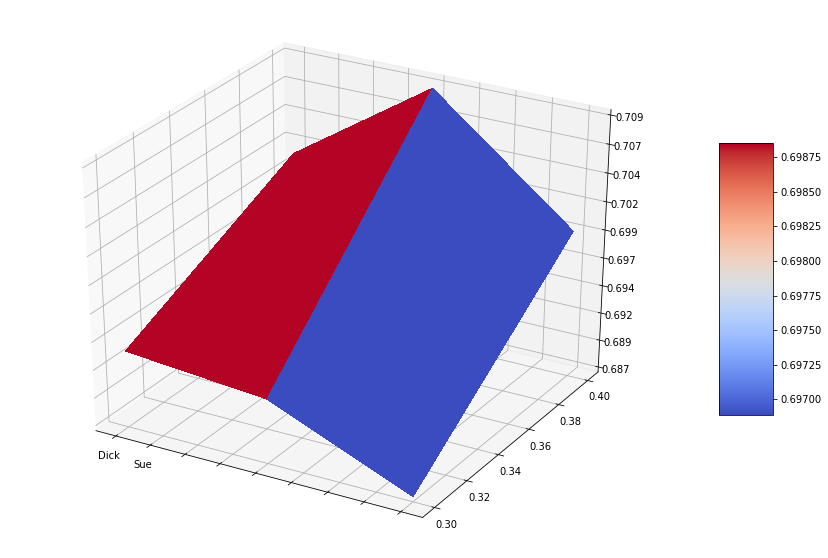

In [102]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

X = [x for x, _ in enumerate(clf.param_grid['layers_dim'])]
Y = clf.param_grid['emb_dropout']
Z = clf.cv_results_['mean_test_score'].reshape(-1, len(X))
X, Y = np.meshgrid(X, Y)


fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, 
                       Y, 
                       Z,
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))
ax.set_xticklabels(['Tom', 'Dick', 'Sue'])
fig.colorbar(surf, shrink=0.5, aspect=5)

## Score vs Epoch

In [ ]:
sentence_train_f1_history = np.zeros(shape=(num_epoch,))
sentence_val_f1_history = np.zeros(shape=(num_epoch,))
threshold = None

for train_index, val_index in kf.split(train_texts):
    classifier = SentenceAspectClassifier(num_epoch=num_epoch, **sentence_best_params_)
    t, v = classifier.fit(
        train_texts=[train_texts[x] for x in train_index], 
        val_texts=[train_texts[x] for x in val_index],
        vocabulary=vocabulary, 
        embeddings=embeddings_matrix)
    sentence_train_f1_history += t
    sentence_val_f1_history += v
    if threshold is not None:
        threshold += classifier.threshold
    else:
        threshold = classifier.threshold
sentence_train_f1_history /= splits_number
sentence_val_f1_history /= splits_number
threshold /= splits_number

In [ ]:
%store sentence_train_f1_history sentence_val_f1_history threshold

In [ ]:
%store -r

In [ ]:
display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=sentence_train_f1_history,
              val_values=sentence_val_f1_history,
              score_name='F1 score')
plt.savefig(os.path.join(images_path, 'sentence_level_aspect_classifier_f1_vs_epoch.pdf'))

## Test

### Fit

In [ ]:
classifier = SentenceAspectClassifier(**sentence_best_params_)
_ = classifier.fit(train_texts=train_texts,
                   init_threshold=threshold,
                   fixed_threshold=True,
                   vocabulary=vocabulary,
                   embeddings=embeddings_matrix)

### Predict

In [ ]:
test_texts_pred = copy.deepcopy(test_texts)
for text in test_texts_pred:
    text.reset_opinions()

test_texts_pred = classifier.predict(test_texts_pred)
score = classifier.score(test_texts)
score

In [ ]:
stop

# Opinion-Level Aspect Classification

### Optimal epoch

In [ ]:
num_epoch = 100
opinion_train_f1_history = np.zeros(shape=(num_epoch), dtype=np.float)
opinion_val_f1_history = np.zeros(shape=(num_epoch), dtype=np.float)

for train_index, val_index in kf.split(train_texts):
    classifier = OpinionAspectClassifier(vocabulary=vocabulary,
                                         emb_matrix=embeddings_matrix)
    t, v = classifier.fit(
        train_texts=[train_texts[x] for x in train_index], 
        val_texts=[train_texts[x] for x in val_index],
        num_epoch=num_epoch)
    opinion_train_f1_history += t
    opinion_val_f1_history += v
opinion_train_f1_history /= splits_number
opinion_val_f1_history /= splits_number

In [ ]:
%store opinion_train_f1_history opinion_val_f1_history

In [ ]:
%store -r

In [ ]:
display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=opinion_train_f1_history,
              val_values=opinion_val_f1_history,
              score_name='F1 score')
plt.savefig(os.path.join(images_path, 'opinion_level_aspect_classifier_f1_vs_epoch.pdf'))

### Fit

In [ ]:
classifier = OpinionAspectClassifier(vocabulary=vocabulary,
                                     emb_matrix=embeddings_matrix)
_ = classifier.fit(train_texts=train_texts)

### Predict

In [ ]:
test_texts_pred = classifier.predict(test_texts_pred)
score = classifier.score(texts=test_texts, texts_pred=test_texts_pred)
print(f'{score}')